## Config

In [25]:
# parameters
INPUT_DATA_PATH = "../data/interim/"
INPUT_PROCESSED_DATA_PATH = "../data/processed/"
MODELS_PATH = "../models/"
PLOTS_PATH = "../reports/figures/"

YEARS = [2017, 2018, 2019, 2020,2021,2022,2023,2024]
SIZE_PLOTS = (30,30)

SAVE_OUTPUT = True
OUTPUT_DATA_PATH = "../data/interim/"


In [23]:
import numpy as np
import pandas as pd
import geopandas as gpd
import papermill as pm
import os
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Load data

In [4]:
df = pd.read_csv(OUTPUT_DATA_PATH + 'indices.csv')


# Make plots

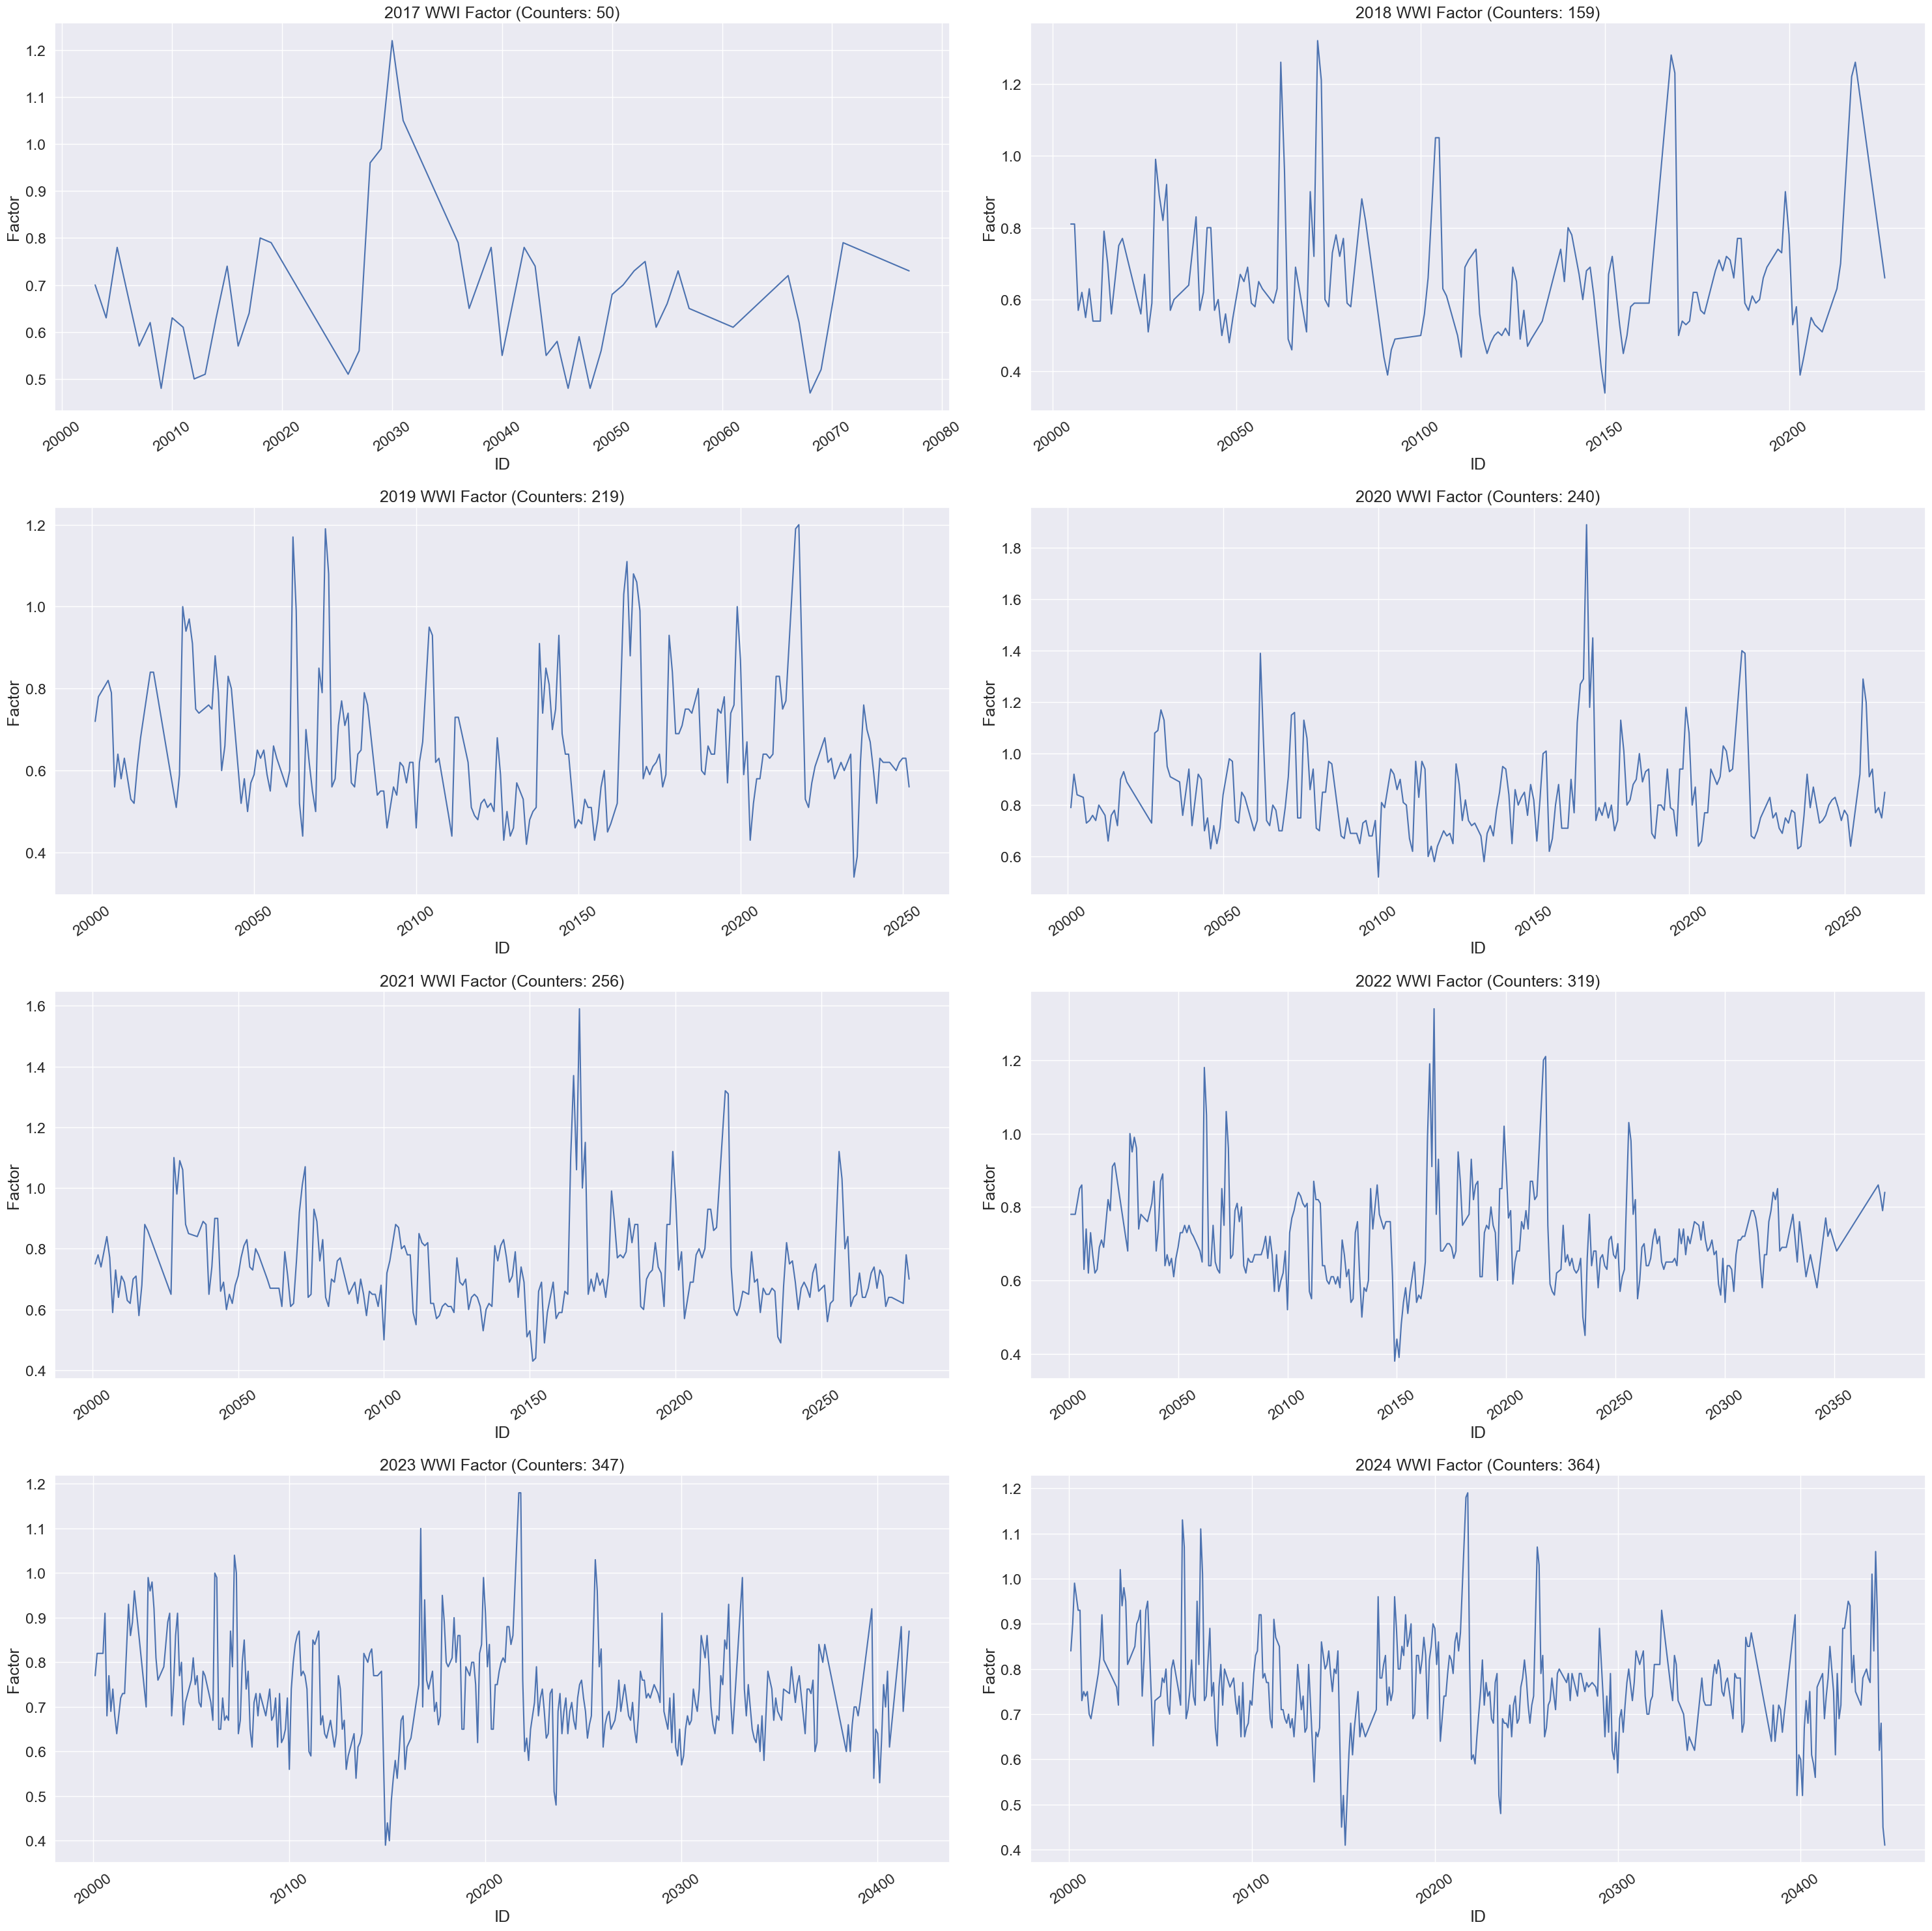

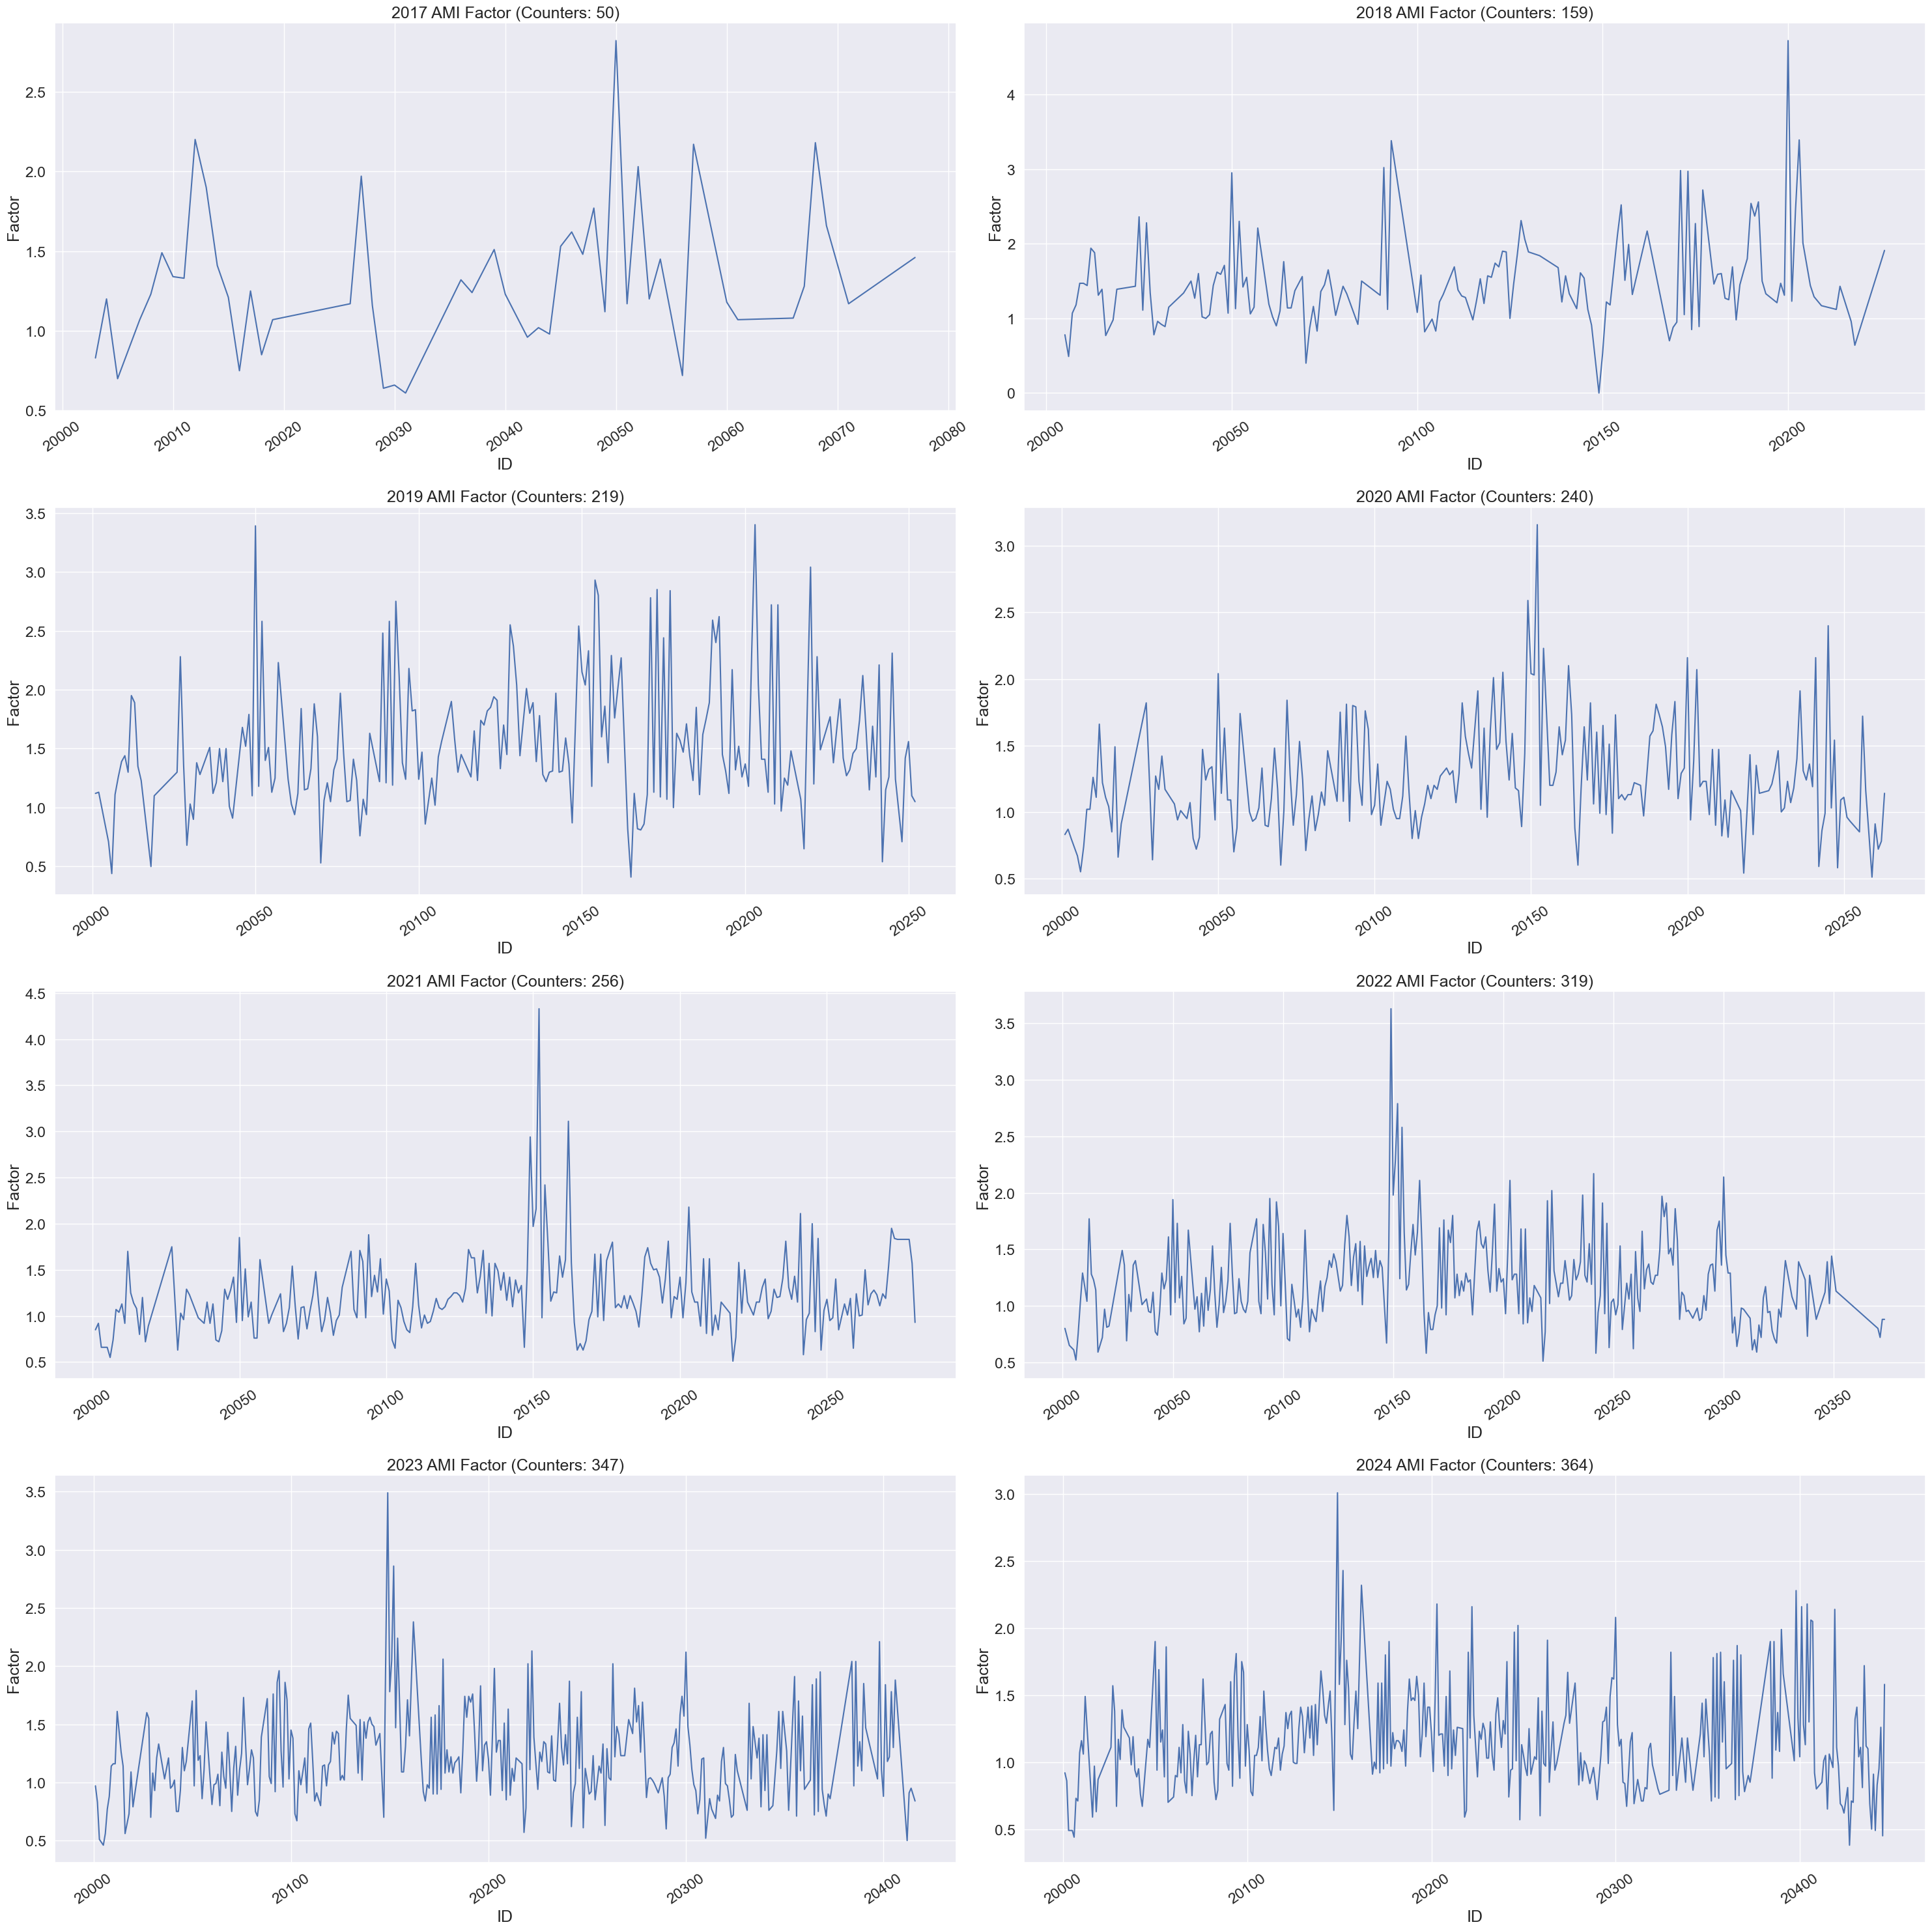

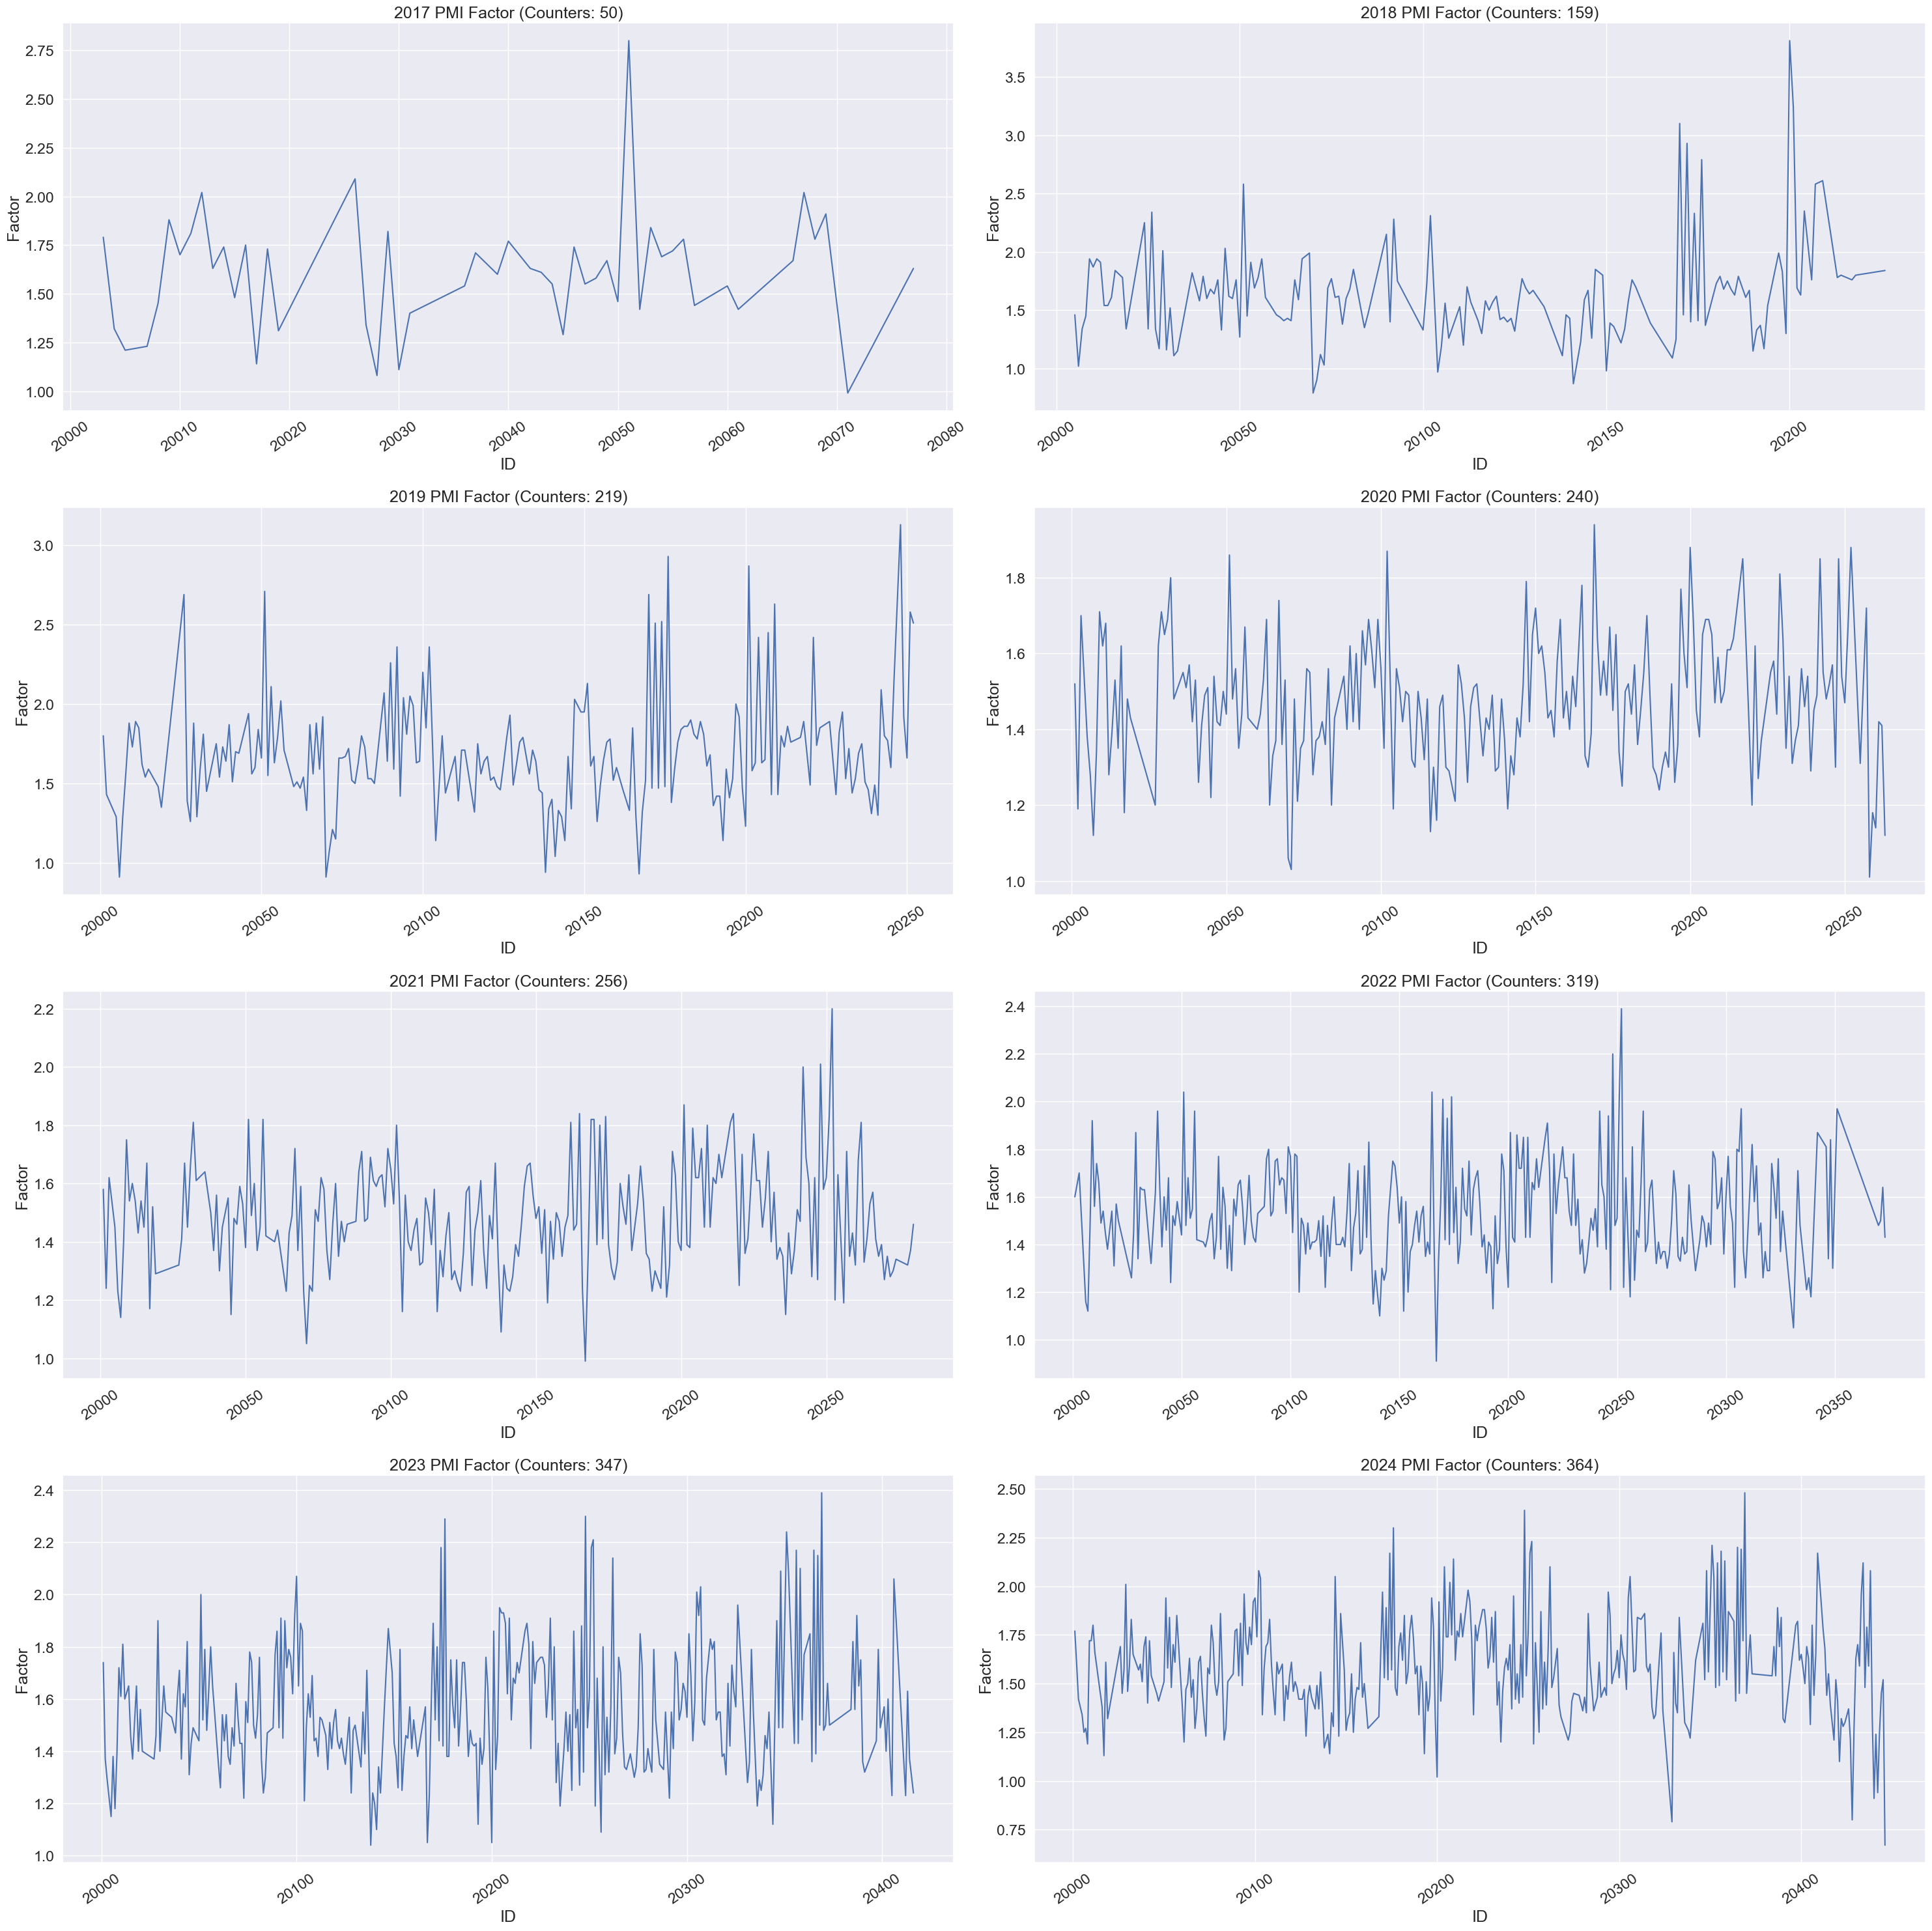

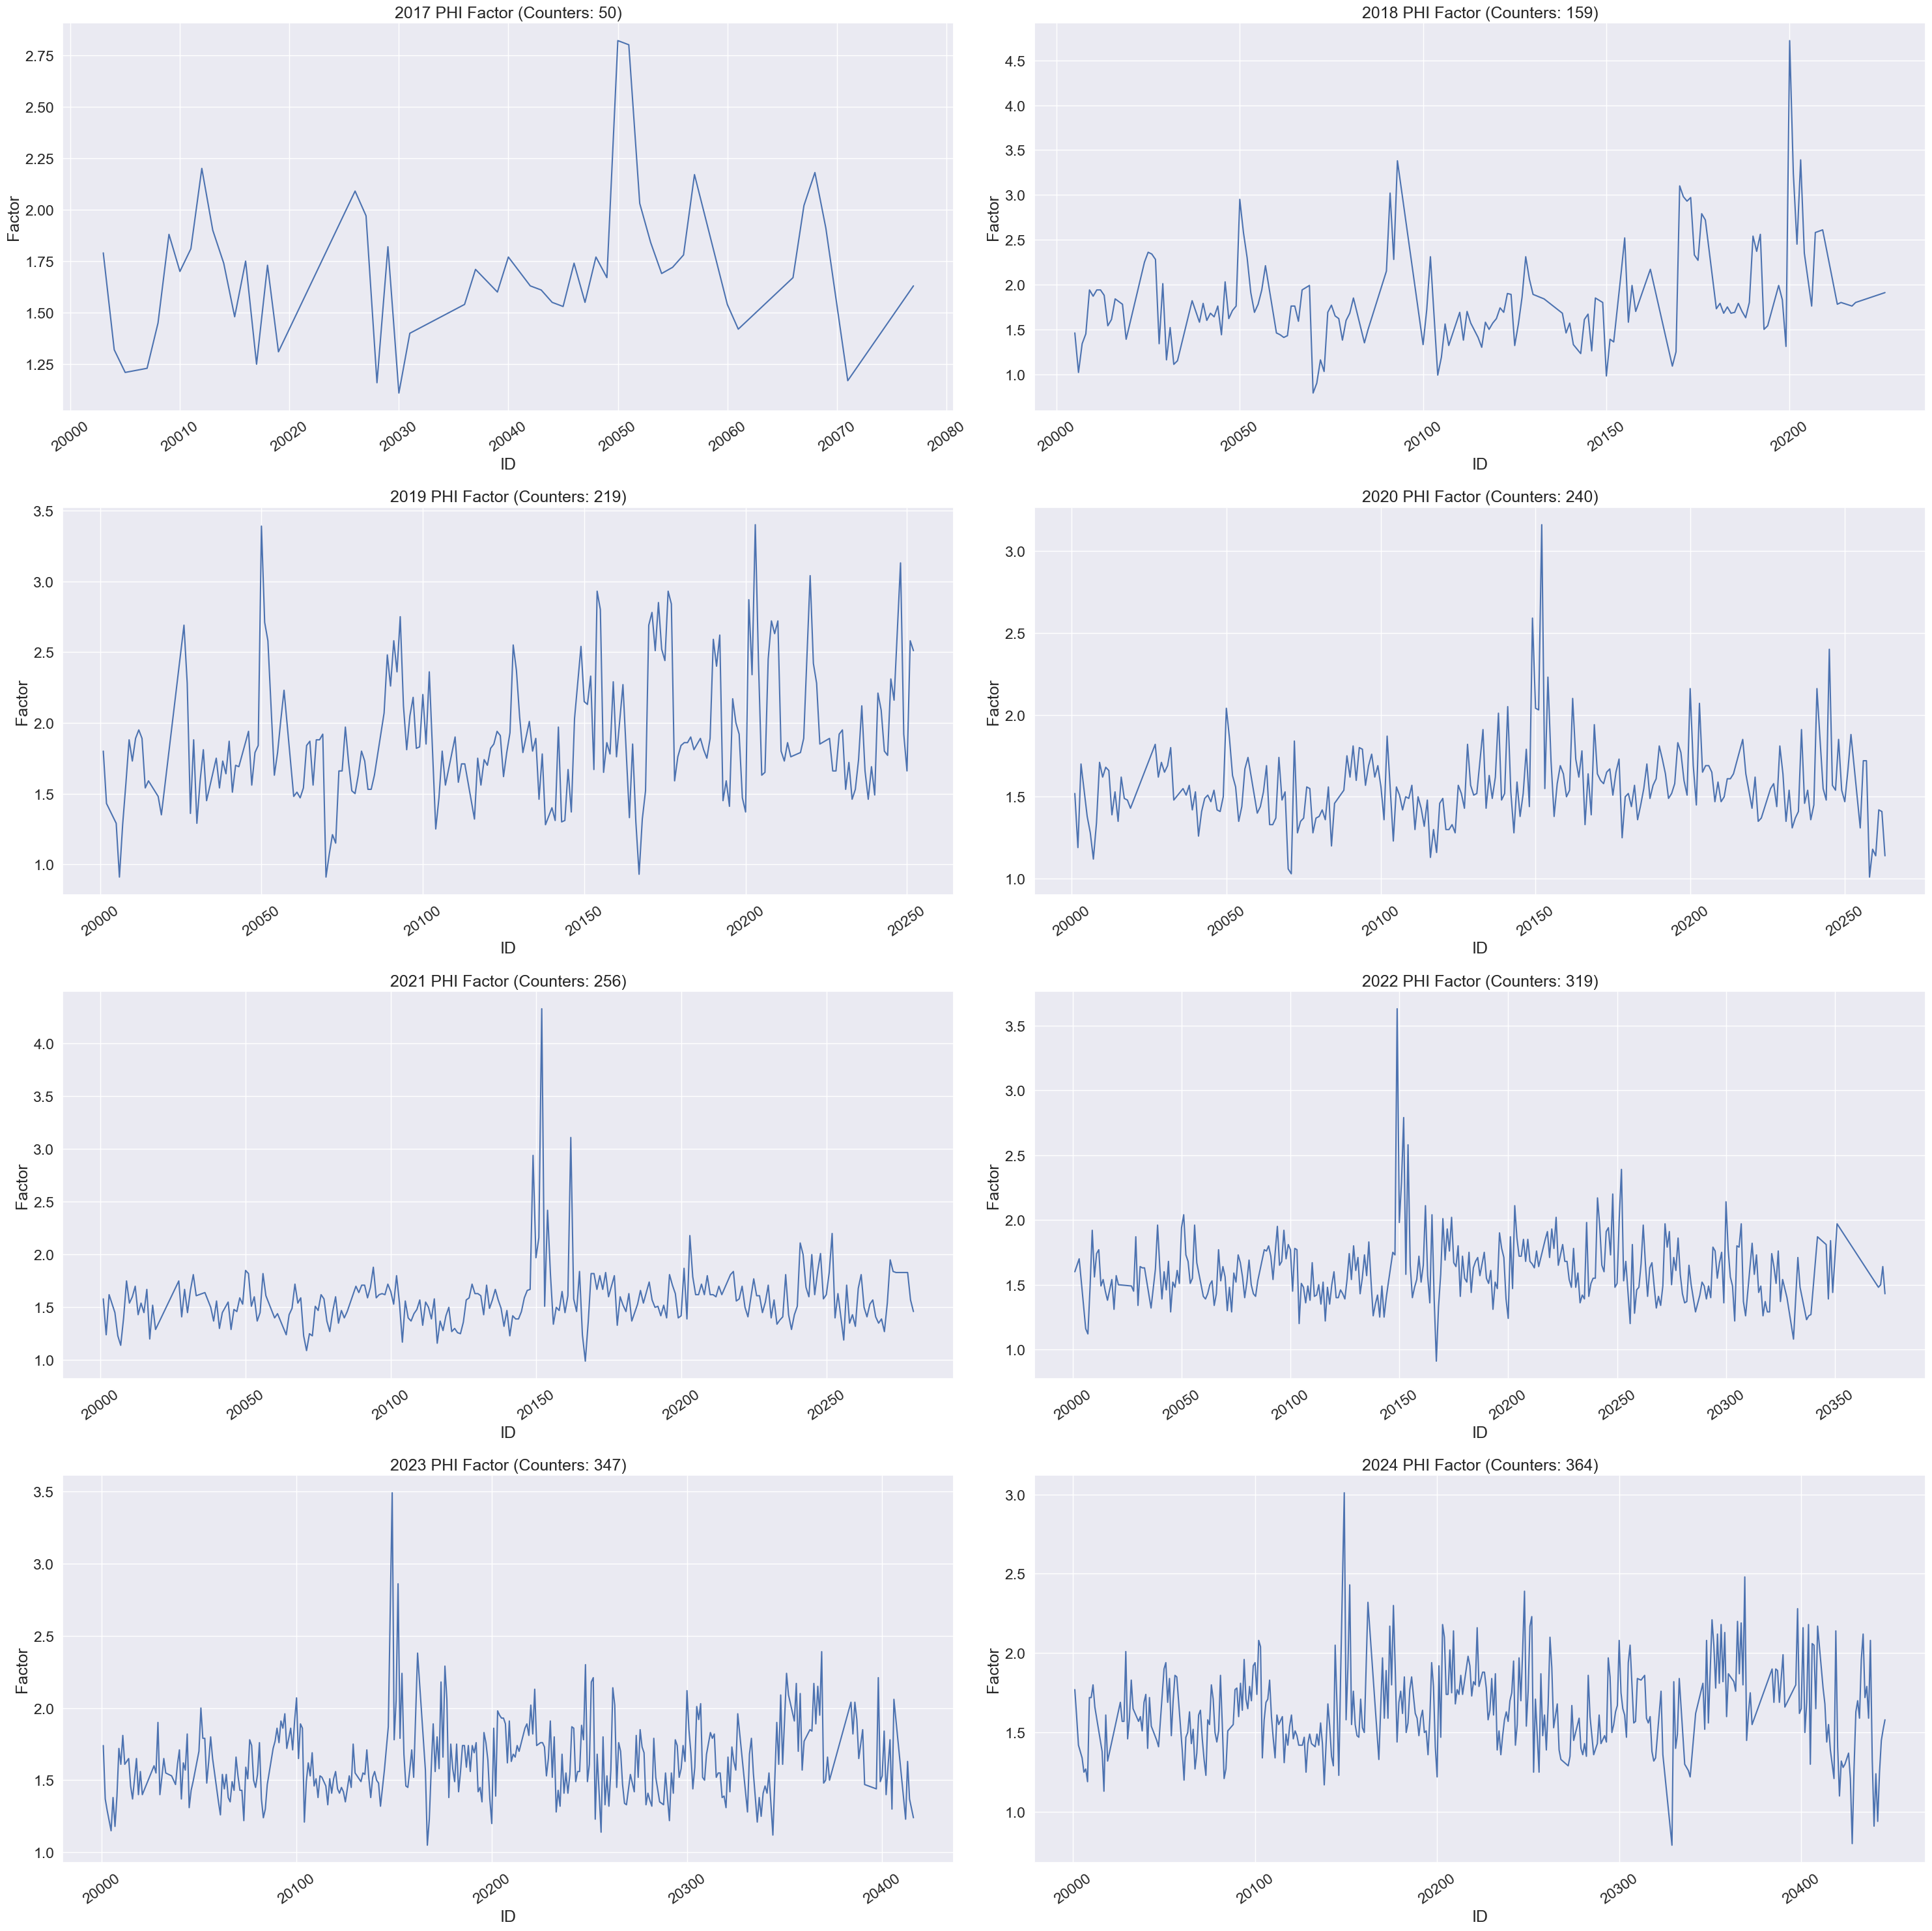

In [ ]:
#Plot WWI per year

sns.set(rc={'figure.figsize': SIZE_PLOTS})
sns.set(font_scale=1.5)

def plot_indicator_per_year(df, years, indicator, size_plots, output_path):
    num_years = len(years)
    num_cols = 2
    num_rows = (num_years + 1) // num_cols
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=size_plots)
    ax = ax.flatten()
    
    for i, year in enumerate(years):
        ami = df.loc[df['year'] == year]
        sns.lineplot(x=ami['id'], y=ami[indicator], dashes=False, sort=True, ax=ax[i])
        num_counters = ami['id'].nunique()
        ax[i].set_title(f'{year} {indicator} Factor (Counters: {num_counters})')
        ax[i].set_ylabel(f'Factor')
        ax[i].set_xlabel('ID')
        ax[i].tick_params(axis='x', rotation=35)
    
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
    
    plt.tight_layout()
    plt.savefig(Path(output_path)/f'index_{indicator}_per_year.png')
    #plt.show()


for indicator in ['WWI','AMI', 'PMI', 'PHI']:#['WWI','AMI', 'PMI', 'PHI','SF']
    plot_indicator_per_year(df, YEARS,indicator, SIZE_PLOTS, PLOTS_PATH)


# Cluster

## All years

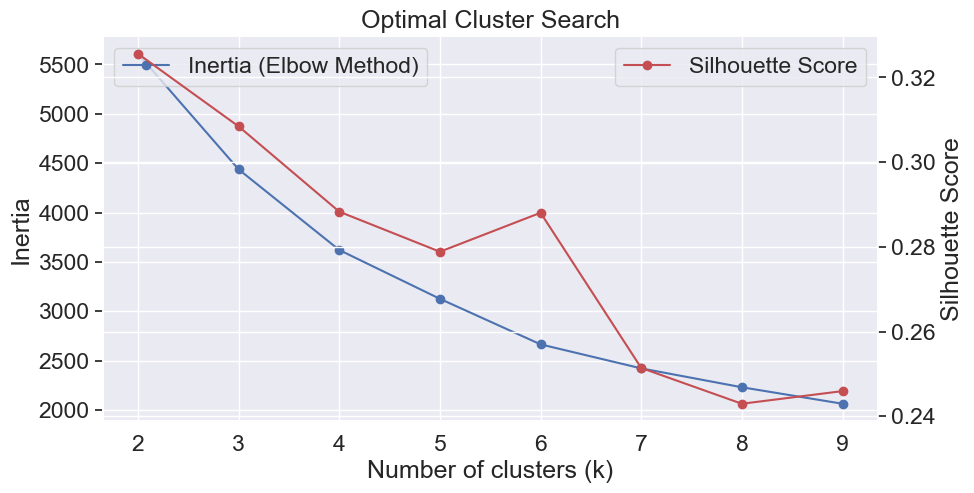

      id  year   WWI   AMI   PMI   PHI  cluster
0  20003  2017  0.70  0.83  1.79  1.79        1
1  20004  2017  0.63  1.20  1.32  1.32        0
2  20005  2017  0.78  0.70  1.21  1.21        2
3  20007  2017  0.57  1.07  1.23  1.23        0
4  20008  2017  0.62  1.23  1.45  1.45        0


cluster
0    927
1    437
2    399
3    191
Name: count, dtype: int64

In [26]:
def cluster_all_years(df):
    # Step 1: Combine indices across all years
    indices_subset = df[['id', 'year', 'WWI', 'AMI', 'PMI', 'PHI']]

    # Step 2: Normalize the indices (excluding 'id' and 'year')
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(indices_subset[['WWI', 'AMI', 'PMI', 'PHI']])

    # Step 3: Find the optimal number of clusters using the Elbow Method
    inertia = []
    silhouette_scores = []
    cluster_range = range(2, 10)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

    # Visualize the Elbow and Silhouette Scores
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cluster_range, inertia, 'bo-', label='Inertia (Elbow Method)')
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Optimal Cluster Search')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(cluster_range, silhouette_scores, 'ro-', label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score')
    ax2.legend(loc='upper right')
    plt.show()

    # Step 4: Choose k (e.g., based on the elbow and silhouette score) and perform clustering
    optimal_k = 4  # Adjust based on visualization
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    indices_subset['cluster'] = final_kmeans.fit_predict(features_scaled)

    # Save the scaler and KMeans model
    joblib.dump(scaler, f'{MODELS_PATH}/scaler.pkl')
    joblib.dump(final_kmeans, f'{MODELS_PATH}/kmeans_model.pkl')
    # Step 5: Return the DataFrame with cluster labels
    return indices_subset

# Usage
clustered_df = cluster_all_years(df)
print(clustered_df.head())

clustered_df["cluster"].value_counts()

## Year by year


Clustering for year: 2017

Clustering for year: 2018

Clustering for year: 2019

Clustering for year: 2020

Clustering for year: 2021

Clustering for year: 2022

Clustering for year: 2023

Clustering for year: 2024
      id   WWI   AMI   PMI   PHI     SF  year  cluster
0  20003  0.70  0.83  1.79  1.79    NaN  2017        2
1  20004  0.63  1.20  1.32  1.32  1.234  2017        2
2  20005  0.78  0.70  1.21  1.21    NaN  2017        0
3  20007  0.57  1.07  1.23  1.23  1.064  2017        2
4  20008  0.62  1.23  1.45  1.45  1.008  2017        2


cluster
2    618
1    531
3    443
0    362
Name: count, dtype: int64

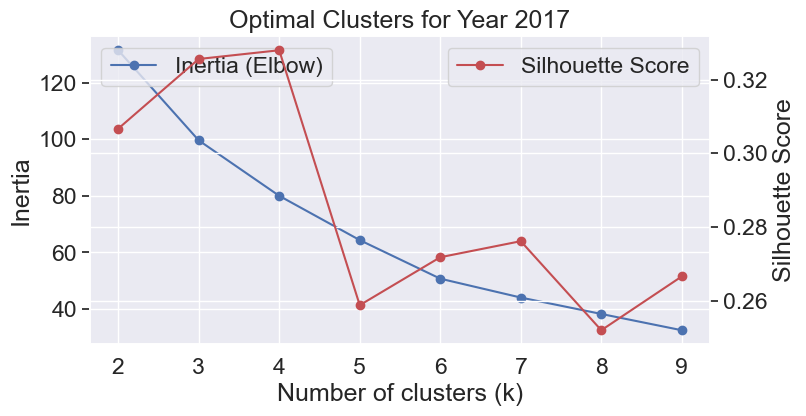

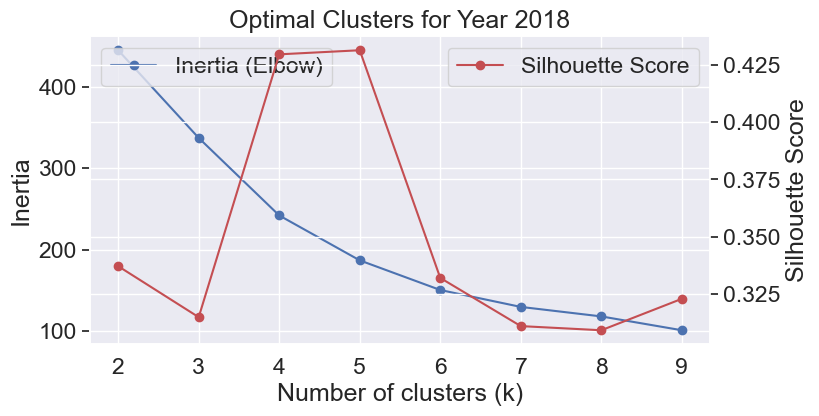

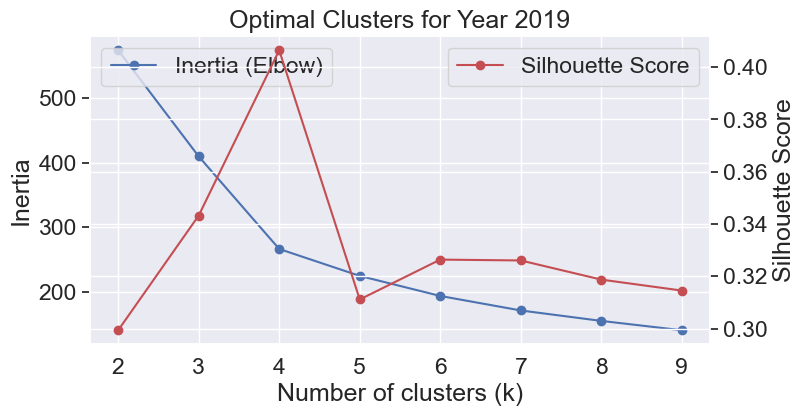

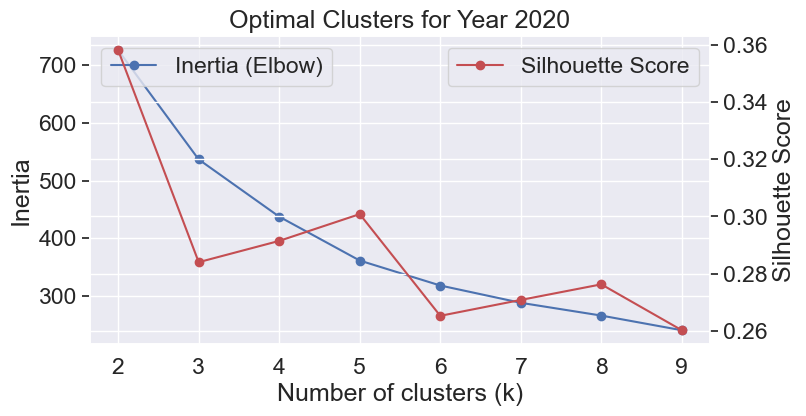

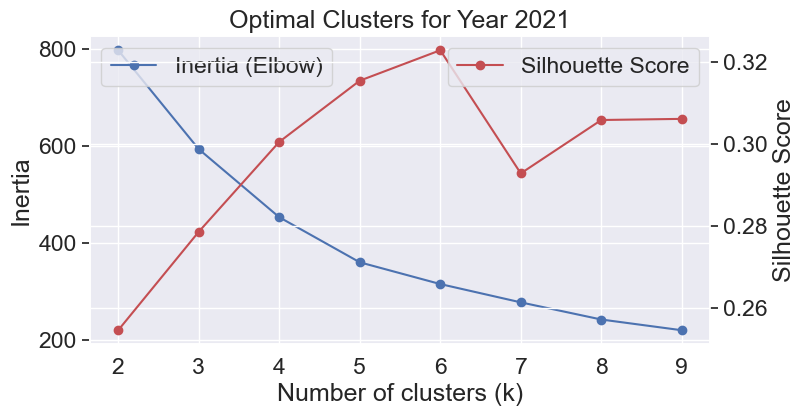

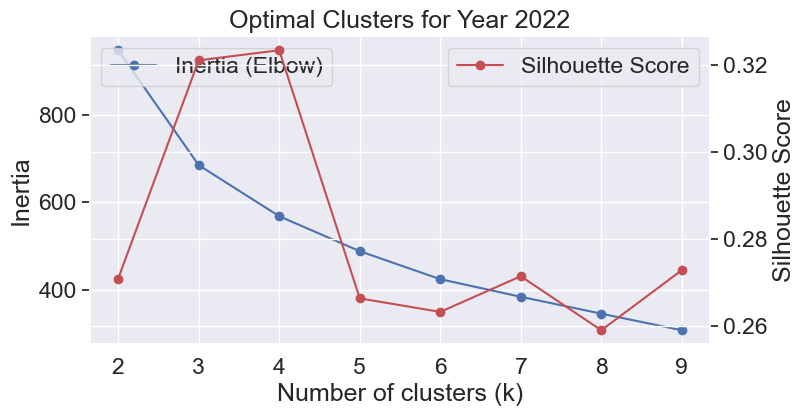

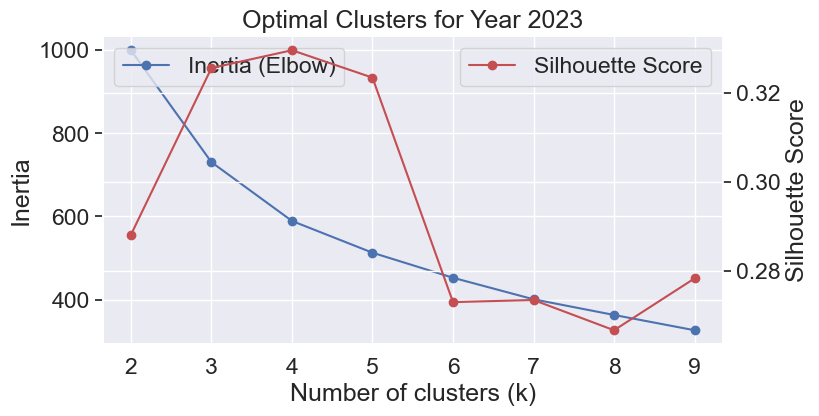

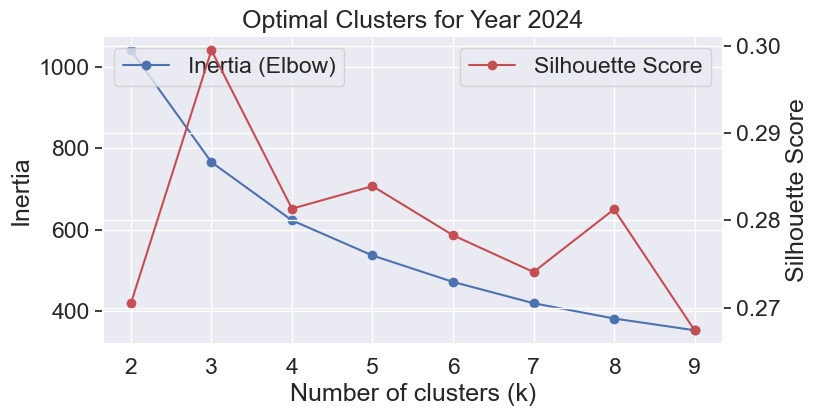

In [13]:
os.environ['OMP_NUM_THREADS'] = '1'

def cluster_by_year(df):
    # Store results
    cluster_results = []

    # Loop through each year
    for year in sorted(df['year'].unique()):
        print(f"\nClustering for year: {year}")

        # Subset data for the current year
        yearly_data = df[df['year'] == year].copy()
        features = yearly_data[['WWI', 'AMI', 'PMI', 'PHI']]

        # Normalize the features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Find optimal clusters using the Elbow and Silhouette method
        inertia = []
        silhouette_scores = []
        cluster_range = range(2, 10)

        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(features_scaled)
            inertia.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

        # Plot the elbow and silhouette scores
        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(cluster_range, inertia, 'bo-', label='Inertia (Elbow)')
        ax1.set_xlabel('Number of clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title(f'Optimal Clusters for Year {year}')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(cluster_range, silhouette_scores, 'ro-', label='Silhouette Score')
        ax2.set_ylabel('Silhouette Score')
        ax2.legend(loc='upper right')
        # plt.show()

        # Choose the optimal k (e.g., based on elbow point or silhouette score)
        optimal_k = 4  # Adjust manually after reviewing the plots

        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        yearly_data['cluster'] = kmeans.fit_predict(features_scaled)

        # Store the results
        cluster_results.append(yearly_data)

    # Combine results for all years
    clustered_df = pd.concat(cluster_results).reset_index(drop=True)
    return clustered_df

# Usage
clustered_df = cluster_by_year(df)
print(clustered_df.head())

clustered_df["cluster"].value_counts()
